<a href="https://colab.research.google.com/github/feliperpv/click-fraud/blob/master/click-fraud-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter para criação do modelo

### Dicionário de dados
Ref: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

```
Each row of the training data contains a click record, with the following features.

- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

- click_id: reference for making predictions
- is_attributed: not included
```

In [1]:
# !pip install imbalanced-learn
# !pip install pingouin

In [2]:
# Packages import
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pingouin as pg

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, plot_roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import chi2

# Definindo constantes
seed = 1997
target = "target"

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Definindo Funções

In [3]:
# Função para realizar o split de dados
def split_dataset(df, inputs, target=target, test_size=0.30, random_state=seed):
    X = df[inputs].values
    y = df[[target]].values
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Função responsável por realizar o encoding das variáveis de entrada
def le_transform_inputs(df_original, train, test, inputs):
    le = LabelEncoder()
    for c in inputs:
        le.fit(df_original[c])
        train.loc[:, c] = le.transform(train.loc[:,c])
        test.loc[:, c] = le.transform(test.loc[:,c])
        
    return train, test

# Função responsável por balancear os dados
def smote_dataset(df, target, random_state=seed):
    smote = SMOTE(random_state=seed)
    X = df.drop([target], axis = 1)
    Y = df[target]

    return smote.fit_sample(X, Y)

# Função responsável por realizar previsões e calcular métricas do modelo
def prediction_and_metrics(clf, X_test, y_test):
    """
    Ref: https://medium.com/@arnaldog12/o-que-n%C3%A3o-te-contam-sobre-m%C3%A9tricas-de-classifica%C3%A7%C3%A3o-bin%C3%A1ria-d1834e385402
    """
    print("Starting prediction and metrics calculation\n")
    preds = clf.predict(X_test)
    
    # Valores possíveis:
    # -1: errando mais do que acerta
    # 1: acertando mais do que erra
    # 0: próximo de 0 o classificador está "chutando"
    mcc = matthews_corrcoef(y_test, preds)
    print(f"Matthews Correlation Coefficient (MCC): {mcc}")
    
    # Indicada para datasets balanceados
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy Score: {accuracy}")
    
    # Das amostras ditas POSITIVAS, quantas realmente são?
    # Quanto você confia na predição da classe POSITIVA
    precision = precision_score(y_test, preds)
    print(f"Precision Score: {precision}")
    
    # Das amostras ditas NEGATIVAS, quantas realmente são?
    # Quanto você confia na predição da classe NEGATIVA
    precision = precision_score(y_test, preds, pos_label=0)
    print(f"Negative Predictive Score: {precision}")
    
    # Das amostras POSITIVAS, quantas o algoritmo acertou?
    # Quão bom o algoritmo é em acertar a classe POSITIVA
    recall = recall_score(y_test, preds)
    print(f"Recall Positivo/Sensitivity Score: {recall}")
    
    # Das amostras NEGATIVAS, quantas o algoritmo acertou?
    # Quão bom o algoritmo é em acertar a classe NEGATIVA
    recall = recall_score(y_test, preds, pos_label=0)
    print(f"Recall Negativo/Specificity Score: {recall}")
    
    # Média harmônica da Precisão e Recall Positivo
    # O que é melhor? 
    # Recall de 30% e precisão de 60%
    # Recall de 20% e precisão de 100%
    f1 = f1_score(y_test, preds)
    print(f"F1 Score: {f1}")

    print("\nCONFUSION MATRIX")
    plot_confusion_matrix(clf, X_test, y_test, values_format="d")
    plt.show()
    
    print("\nROC CURVE")
    plot_roc_curve(clf, X_test, y_test)
    plt.show()

## Importando dados

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/feliperpv/click-fraud/master/data.csv", 
                   parse_dates=['click_time', 'attributed_time'],
                   dtype={
                       'ip': 'category',
                       'app': 'category',
                       'device': 'category',
                       'os': 'category',
                       'channel': 'category',
                       'is_attributed': 'str'}
                   )
data.shape

(100000, 8)

In [5]:
data.columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'target']

In [6]:
data.head()

,ip,app,device,os,channel,click_time,attributed_time,target
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0


In [7]:
data.isna().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
target                 0
dtype: int64

In [8]:
# Alterando variável is_attributed
# 0 -> True -> Fraude
# 1 -> False -> Não Fraude
data.loc[data.target == "0", target] = True
data.loc[data.target == "1", target] = False

In [9]:
# Encoding variável target
le_target = LabelEncoder()
le_target.fit(data.target)
data[target] = le_target.transform(data.target)

## Modelo Versão 1 (Base)

### Pré-processamento

In [10]:
# Removendo colunas que não serão utilizadas
df_base = data.copy()
df_base = df_base.drop(["click_time", "attributed_time"], axis=1)

### Balanceamento das classes

In [11]:
# Realizando a divisão dos dados em treino e teste
inputs = ['ip', 'app', 'device', 'os', 'channel']
X_train, X_test, y_train, y_test = split_dataset(df_base, inputs)

# Verificando as dimensões de cada dataset gerado no split
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70000, 5) (70000, 1)
(30000, 5) (30000, 1)


In [12]:
# Transformando os splits em dataframes
df_base_train = pd.DataFrame(data=X_train, columns=inputs)
df_base_test = pd.DataFrame(data=X_test, columns=inputs)

# Aplicando o balanceamento nos dados de treino
# Realiza o encoding nas variáveis categóricas utilizando o Label Encoder
df_base_train, test_base = le_transform_inputs(df_base, df_base_train[inputs], df_base_test[inputs], inputs)

# Adicionando a váriavel target nos dataframes
df_base_train[target] = y_train
test_base[target] = y_test

In [13]:
# Aplicando balanceamento com SMOTE
X_smote, y_smote = smote_dataset(df_base_train, target)

train_base = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis = 1)
train_base.columns = ['ip', 'app', 'device', 'os', 'channel', 'target']

perc = train_base[target].value_counts(normalize=True)
count = train_base[target].value_counts()

print("Cliques considerados FRAUDE: {:.3f}% ({})".format(perc[0] * 100, count[0]))
print("Cliques considerado NÃO FRAUDE: {:.3f}% ({})".format(perc[1] * 100, count[1]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Cliques considerados FRAUDE: 50.000% (69822)
Cliques considerado NÃO FRAUDE: 50.000% (69822)


### Criação do modelo

In [14]:
# Criando e treinando o modelo
x = train_base.iloc[:,:5].values
y = train_base[target].values

model_base = RandomForestClassifier(random_state=seed)
model_base.fit(x, y.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1997,
                       verbose=0, warm_start=False)

### Métricas

Starting prediction and metrics calculation

Matthews Correlation Coefficient (MCC): 0.28160156594151026
Accuracy Score: 0.9957333333333334
Precision Score: 0.9990962948087158
Negative Predictive Score: 0.17886178861788618
Recall Positivo/Sensitivity Score: 0.9966278254482321
Recall Negativo/Specificity Score: 0.4489795918367347
F1 Score: 0.997860533529451

CONFUSION MATRIX


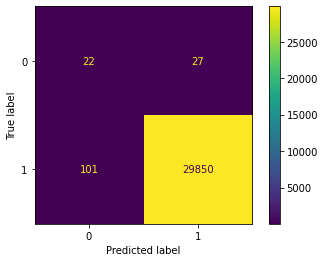


ROC CURVE


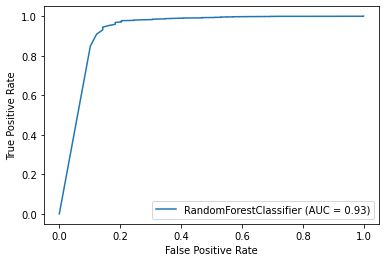

In [15]:
# Realizando previsões e calculando métricas
x_test = test_base.iloc[:,:5].values
y_test = test_base[target].values

prediction_and_metrics(model_base, x_test, y_test.ravel())

## Modelo Versão 2

### Pré-processamento

In [16]:
# Adicionando variáveis de tempo
df_model_2 = data.copy()
df_model_2["hour"] = df_model_2["click_time"].dt.hour.astype('uint8')
df_model_2["minute"] = df_model_2["click_time"].dt.minute.astype('uint8')
df_model_2["second"] = df_model_2["click_time"].dt.second.astype('uint8')
df_model_2["dayofweek"] = df_model_2["click_time"].dt.dayofweek.astype('uint8')

df_model_2 = df_model_2.drop(["click_time", "attributed_time"], axis=1)

df_model_2.head()

,ip,app,device,os,channel,target,hour,minute,second,dayofweek
0,87540,12,1,13,497,1,9,30,38,1
1,105560,25,1,17,259,1,13,40,27,1
2,101424,12,1,19,212,1,18,5,24,1
3,94584,13,1,13,477,1,4,58,8,1
4,68413,12,1,1,178,1,9,0,9,3


### Balanceamento das classes

In [17]:
# Realizando a divisão dos dados em treino e teste
inputs = ['ip', 'app', 'device', 'os', 'channel', 'hour', 'minute', 'second', 'dayofweek']
X_train, X_test, y_train, y_test = split_dataset(df_model_2, inputs)

# Transformando arrays em dataframes
df_model_2_train = pd.DataFrame(data=X_train, columns=inputs)
df_model_2_test = pd.DataFrame(data=X_test, columns=inputs)

# Encoding das variáveis categóricas utilizando o Label Encoder
cat_col = ['ip', 'app', 'device', 'os', 'channel', 'dayofweek']
train_model_2, test_model_2 = le_transform_inputs(df_model_2, df_model_2_train.loc[:,cat_col], df_model_2_test.loc[:,cat_col], cat_col)

# Adicionando as variáveis numéricas nos dataframes
num_col = ["hour", "minute", "second"]
for c in num_col:
    train_model_2[c] = df_model_2_train.loc[:,c]
    test_model_2[c] = df_model_2_test.loc[:,c]
    
# Adicionando a váriavel target nos dataframes
train_model_2[target] = y_train
test_model_2[target] = y_test

# # Aplicando smote
X_smote, y_smote = smote_dataset(train_model_2, target)
train_model_2 = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis = 1)

train_model_2.columns = ['ip', 'app', 'device', 'os', 'channel', 'hour', 'minute', 'second', 'dayofweek', "target"]
test_model_2.columns = ['ip', 'app', 'device', 'os', 'channel', 'hour', 'minute', 'second', 'dayofweek', "target"]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [18]:

train_model_2.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'hour', 'minute', 'second',
       'dayofweek', 'target'],
      dtype='object')

### Criação do modelo

In [19]:
# Criando e treinando o modelo
x = train_model_2.iloc[:,:9].values
y = train_model_2["target"].values

model_v2 = RandomForestClassifier(random_state=seed)
model_v2.fit(x, y.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1997,
                       verbose=0, warm_start=False)

### Métricas

Starting prediction and metrics calculation

Matthews Correlation Coefficient (MCC): 0.22763120149793098
Accuracy Score: 0.9977333333333334
Precision Score: 0.9986983078001401
Negative Predictive Score: 0.2564102564102564
Recall Positivo/Sensitivity Score: 0.9990317518613736
Recall Negativo/Specificity Score: 0.20408163265306123
F1 Score: 0.9988650020029376

CONFUSION MATRIX


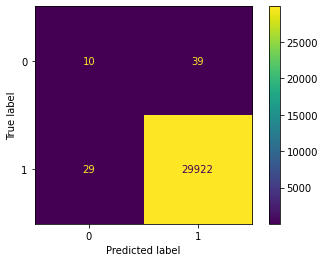


ROC CURVE


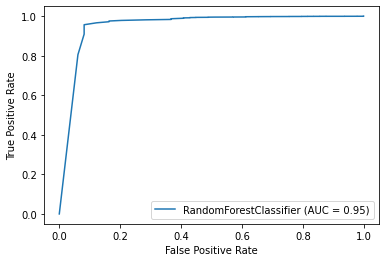

In [20]:
# Realizando previsões e calculando métricas
x_test = test_model_2.iloc[:,:9].values
y_test = test_model_2[target].values

prediction_and_metrics(model_v2, x_test, y_test.ravel())

### Feature Importance

#### Feature importance do modelo Random Forest

In [21]:
# Extraindo a importância
importances = model_v2.feature_importances_
indices = np.argsort(importances)[::-1]
# print(indices)
# print(importances)

In [22]:
columns = train_model_2.columns[:-1]
for f in range(X_test.shape[1]):
    idx = indices[f]
    print(f"{f}. feature {idx} - {columns[idx]} ({importances[idx]})")

0. feature 2 - device (0.2697267067709936)
1. feature 1 - app (0.2529375749038954)
2. feature 0 - ip (0.1348357647578543)
3. feature 3 - os (0.11727207760064014)
4. feature 4 - channel (0.0785194381401339)
5. feature 5 - hour (0.07304431473909208)
6. feature 6 - minute (0.031669300740728525)
7. feature 8 - dayofweek (0.02140527472396812)
8. feature 7 - second (0.02058954762269396)


#### Feature Importance variáveis categóricas (usando chi2)

Ref: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [23]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

cat_col = ['ip', 'app', 'device', 'os', 'channel', 'dayofweek']
x_chi2 = train_model_2[cat_col].values
y_chi2 = train_model_2["target"].values

chi_scores = chi2(x_chi2, y_chi2)

scores = pd.Series(chi_scores[0], index=cat_col)
pvalues = pd.Series(chi_scores[1], index=cat_col)

pd.DataFrame({'Chi2':scores, 'p-Value':pvalues})

,Chi2,p-Value
ip,3303664.9675,0.0000
app,66741.7049,0.0000
device,167377.6945,0.0000
os,1041.1781,0.0000
channel,97534.8732,0.0000
dayofweek,752.2140,0.0000


- Quanto maior o Chi2 e menor o p-value mais dependente o atributo é da váriavel target

#### Feature Importance variáveis numéricas (usando ANOVA)

Ref: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [24]:
# Calculando a estatística com ANOVA
aov = []
for variance in train_model_2.columns[:9]:
    v = pg.anova(data=train_model_2, dv='target', between=variance, detailed=True).round(3)
    aov.append(v)

In [25]:
aov_result = pd.concat(aov)
aov_result = aov_result[aov_result.Source != "Within"][['Source', 'F']]
aov_result.sort_values(by="F", ascending=False)

,Source,F
0,app,50.7390
0,dayofweek,48.1390
0,channel,42.7740
0,ip,37.4390
0,second,25.4100
0,os,11.1840
0,minute,10.3440
0,device,1.8550
0,hour,1.6210


- Quanto maior o valor de F maior a evidência de que as variáveis são diferentes e exercem influência uma sobre a outra

## Modelo versão 3

- Com base nos testes de Feature Importance o modelo três conterá as seguintes váriaveis:
    - ip
    - app
    - os
    - device
    - channel
    - dayofweek

### Pré-processamento

In [26]:
train_model_3 = train_model_2.copy()
test_model_3 = test_model_2.copy()

cols = ["ip", "app", "os", "device", "channel", "dayofweek", "target"]
train_model_3 = train_model_3.loc[:,cols]
test_model_3 = test_model_3.loc[:,cols]

### Criação do modelo

In [27]:
# Criando e treinando o modelo
x = train_model_3.iloc[:,:6].values
y = train_model_3["target"].values

model_v3 = RandomForestClassifier(random_state=seed)
model_v3.fit(x, y.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1997,
                       verbose=0, warm_start=False)

### Métricas

Starting prediction and metrics calculation

Matthews Correlation Coefficient (MCC): 0.25905185155771265
Accuracy Score: 0.9973333333333333
Precision Score: 0.9988310343675896
Negative Predictive Score: 0.23728813559322035
Recall Positivo/Sensitivity Score: 0.9984975459917866
Recall Negativo/Specificity Score: 0.2857142857142857
F1 Score: 0.9986642623388767

CONFUSION MATRIX


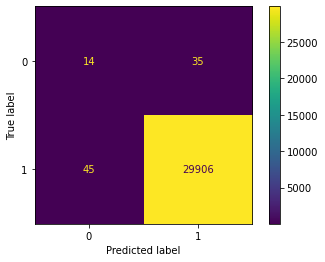


ROC CURVE


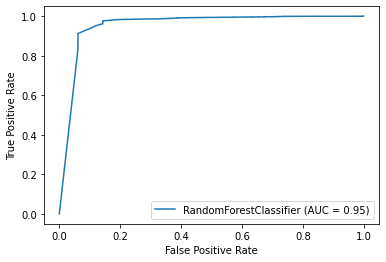

In [28]:
# Realizando previsões e calculando métricas
x_test = test_model_3.iloc[:,:6].values
y_test = test_model_3[target].values

prediction_and_metrics(model_v3, x_test, y_test.ravel())

## Considerações Finais

- O modelo escolhido foi o da versão 3 por apresentar MCC e precisão maiores, bem como um aumento na assertividade de cliques NÃO FRAUDE mantendo a taxa de acertos de cliques FRAUDULENTOS alta.
- Pontos de melhorias:
    - Aplicação da Otimização de parâmetros no modelo criado
    - Aprimorar o tratamento de váriaveis de tempo (Um abordagem possível: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/)
    - Testar outros modelos de Classificação